Below is a practical test of the hypothesis defined in my blog: https://dataanalyticsforall.blogspot.com .
Hypothesis on how to reduce forecasting error using SARIMAX model and exog data is available at:       
https://dataanalyticsforall.blogspot.com/2021/04/weird-aspects-of-arima-how-to-increase.html

As data for predictions, we chose data 'a10: Monthly anti-diabetic drug sales' in Australia available from:
https://raw.githubusercontent.com/selva86/datasets/master/a10.csv .
In the following analysis, we have used suggestions from  https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/


In [229]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pmdarima as pm

As an error for comparisons I will use mean_absolute_percentage_error (mape)

In [189]:
# mean_absolute_percentage_error:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

The available data looks as follows

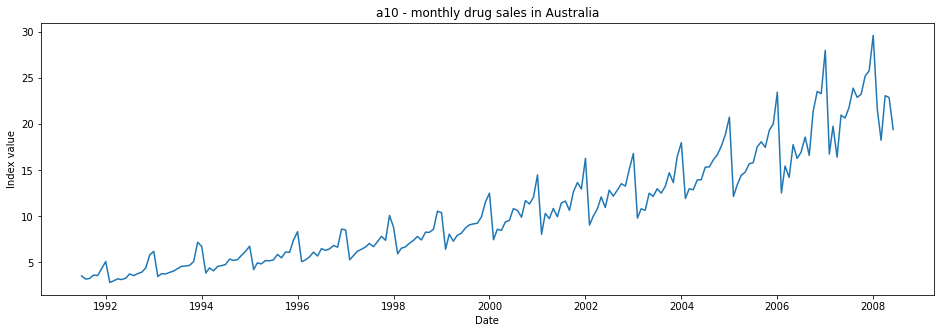

In [190]:
xlabel='Date'
ylabel='Index value'
title='a10 - monthly drug sales in Australia'
plt.figure(figsize=(16,5))
plt.plot(data.index, data.value)
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()

As an exogenous data I will use the seasonal behaviour extracted from the original data. 
So I calculate seasonality so that it can be forced as an (exogenous) predictor into the SARIMAX model.

In [ ]:
# Compute Seasonal Index

In [230]:
# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-20*12:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq',period=12)

seasonality = result_mul.seasonal[-12:].to_frame()
seasonality['month'] = pd.to_datetime(seasonality.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonality, how='left', on='month')
df.columns = ['value', 'month', 'seasonality']
df.index = data.index  # reassign the index.

In [235]:
df.head()

,value,month,seasonality
date,,,
1991-07-01,3.526591,7,0.987845
1991-08-01,3.180891,8,0.990481
1991-09-01,3.252221,9,0.987476
1991-10-01,3.611003,10,1.048329
1991-11-01,3.565869,11,1.074527


As can be seen from the chart below, the ratio between the stochastic and seasonal parts is acceptable. 

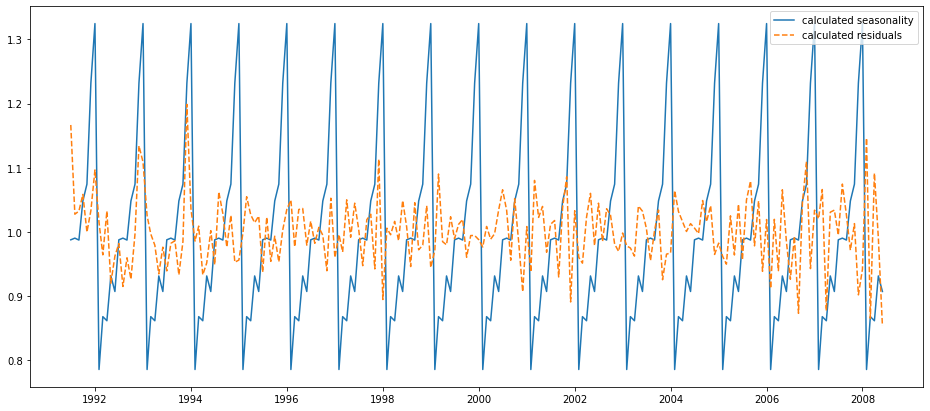

In [233]:
plt.figure(figsize=(16,7))
plt.plot(result_mul.seasonal,label='calculated seasonality')
plt.plot(result_mul.resid,'--',label='calculated residuals')
plt.legend()

I will predict the last 24 months of available data. So, I am splitting out the training and testing data: 

In [8]:
# the same data we would like to predict:

In [248]:
to_forecast = 24
train = df[:-24].copy()
test = df[-24:].copy()

First, I compute predictions without exogenous data using the following model:

In [249]:
# stepwise auto-ARIMA
smodel = pm.auto_arima(train.value.values, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=0, seasonal=True,
                         d=None, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=331.086, Time=1.16 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=369.596, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=362.402, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=367.046, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=546.314, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=332.975, Time=0.18 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=329.553, Time=2.94 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=335.082, Time=6.73 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=368.302, Time=0.93 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=362.333, Time=1.32 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=323.157, Time=2.53 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=323.874, Time=1.18 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=325.369, Time=7.67 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   

In [250]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  180
Model:             SARIMAX(2, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -154.579
Date:                                 Tue, 06 Apr 2021   AIC                            323.157
Time:                                         20:48:50   BIC                            345.025
Sample:                                              0   HQIC                           332.032
                                                 - 180                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1151      0.062      1.859      0.063      -0.006       0.236
ar.L1          0.5564      0.127      4.369      0.000       0.307       0.806
ar.L2          0.3255      0.095      3.414      0.001       0.139       0.512
ma.L1         -0.4932      0.125     -3.937      0.000      -0.739      -0.248
ma.S.L12      -0.1378      0.078     -1.766      0.077      -0.291       0.015
ma.S.L24      -0.1445      0.087     -1.654      0.098      -0.316       0.027
sigma2         0.3655      0.035     10.486      0.000       0.297       0.434
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                10.88
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.36   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The prediction error for the last 24 months is 13.79%. The prediction itself is shown on the chart below.

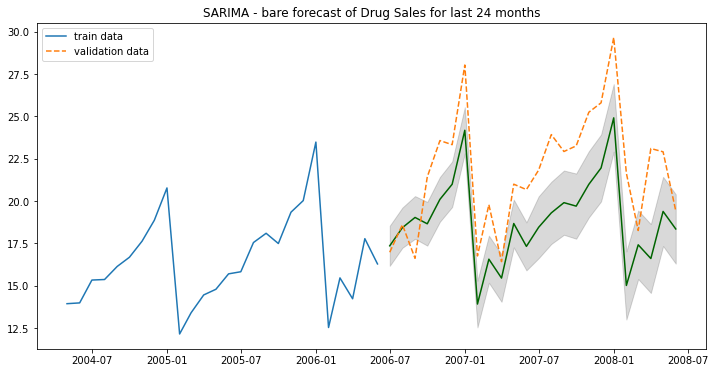

MAPE error =  13.786668078409484


In [251]:
# Forecast
n_periods = to_forecast # next 24 months
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(test.index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index[-26:],train.value.values[-26:],label='train data')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.plot(test.index,test.value.values,'--',label='validation data')
plt.title("SARIMA - bare forecast of Drug Sales for last 24 months")
plt.legend()
plt.show()
err_ = mape(test.value.values, fitted)
print ('MAPE error = ',err_)

Having determined the benchmark value for our experiment, let us now define a second model - with calculated exogenous data

In [252]:
# now with exageneous data:

In [257]:
# SARIMAX Model
sxmodel = pm.auto_arima(train[['value']], exogenous=train[['seasonality']],
                         start_p=1, start_q=1,
                         test='adf',
                         max_p=2, max_q=2, m=12,
                         start_P=0, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True) 

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=333.086, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=371.596, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=364.402, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=369.046, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=548.314, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=334.975, Time=0.18 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=331.553, Time=4.43 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=336.550, Time=7.14 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=370.302, Time=1.29 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=364.333, Time=2.28 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=325.157, Time=2.61 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=325.874, Time=1.22 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=327.228, Time=7.17 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  180
Model:             SARIMAX(2, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -154.579
Date:                                 Tue, 06 Apr 2021   AIC                            325.157
Time:                                         20:52:59   BIC                            350.149
Sample:                                     07-01-1991   HQIC                           335.300
                                          - 06-01-2006                                         
Covariance Type:                                   opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.1151      0.062      1.859      0.063      -0.006       0.237
seasonality  7.443e-07   3.12e-09    238.400      0.000    7.38e-07     7.5e-07
ar.L1           0.5564      0.127      4.369      0.000       0.307       0.806
ar.L2           0.3255      0.095      3.414      0.001       0.139       0.512
ma.L1          -0.4932      0.125     -3.937      0.000      -0.739      -0.248
ma.S.L12       -0.1377      0.078     -1.766      0.077      -0.291       0.015
ma.S.L24       -0.1445      0.087     -1.654      0.098      -0.316       0.027
sigma2          0.3655      0.035     10.485      0.000       0.297       0.434
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                10.88
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.36   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.45e+17. Standard errors may be unstable.
"""

As you can see, both models (with and without exogenous data) have identical parameters:
ARIMA(2,0,1)(0,1,2)[12]  .

The predictions of the model with exogenous data are shown in the graph below. The mape error is 13.79%.

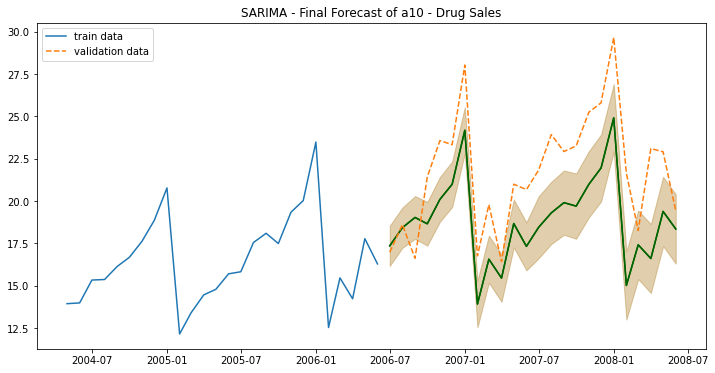

MAPE error =  13.786764865405809


In [260]:
# Forecast
n_periods = to_forecast # next 24 months
fitted_f, confint_f = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=test[['seasonality']].values,#test.seasonal_index.values.reshape(-1,1),#np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(test.index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series_f = pd.Series(fitted_f, index=index_of_fc)
lower_series_f = pd.Series(confint_f[:, 0], index=index_of_fc)
upper_series_f = pd.Series(confint_f[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index[-26:],train.value.values[-26:],label='train data')
plt.plot(fitted_series_f, color='darkgreen')
plt.fill_between(lower_series_f.index, 
                 lower_series_f, 
                 upper_series_f, 
                 color='k', alpha=.15)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='orange', alpha=.2)
plt.plot(test.index,test.value.values,'--',label='validation data')
plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.legend()
plt.show()
err_f = mape(test.value.values, fitted_f)
print ('MAPE error = ',err_f)

A closer comparison of the errors between models: model 1 (without exogenous data) and model 2 (with exogenous data) shows that the prediction error of model 2 is slightly larger: 
model 2: 13.7868 > model 1: 13.7867

This inequality agrees with the theoretical prediction since, in modulus, our exogenous data are much smaller than the data used as target 
(case for alpha << 1). 

Now I will try to multiply the exogenous data by different values and determine the prediction error value

In [335]:
# Forecast
factor = 1000000.
n_periods = to_forecast # next 24 months
fitted_f, confint_f = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=factor*test[['seasonality']].values,
                                  return_conf_int=True)
err_ = mape(test.value.values, fitted)

err_f = mape(test.value.values, fitted_f)
print ('Error comparison: ')
print ('MAPE error for model 1 = ',err_)
print ('MAPE error for model 2 = ',err_f)

Error comparison: 
MAPE error for model 1 =  13.786668078409484
MAPE error for model 2 =  11.307686587004067


A list of error values for different values of the factors with the smaller value indicated. 

For a factor of 10 (alpha < 1):  
MAPE error for model 1 =  13.78667 <- smaller,\
MAPE error for model 2 =  13.78674
    
For a factor of 20 (alpha ~ 1):   
MAPE error for model 1 =  13.786668 <- smaller,\
MAPE error for model 2 =  13.786713

For a factor of 50 (alpha > 1):   
MAPE error for model 1 =  13.78666,\
MAPE error for model 2 =  13.78663 <- smaller

For a factor of 100 (alpha > 1):   
MAPE error for model 1 =  13.786668,\
MAPE error for model 2 =  13.786495 <- smaller

For a factor of 1000 (alpha >> 1):   
MAPE error for model 1 =  13.786668,\
MAPE error for model 2 =  13.784039 <- smaller

For a factor of 10000 (alpha >> 1):   
MAPE error for model 1 =  13.786668,\
MAPE error for model 2 =  13.759484 <- smaller

For a factor of 1000000 (alpha >> 1):   
MAPE error for model 1 =  13.78667,\
MAPE error for model 2 =  11.30769 <- smaller


Below I have presented the mape errors for different values of the factors.  
For better visualization factor values on the x-axis are logarithmic (with base 10).   
As you can see, by using an appropriate value of the factor we are able to reduce the prediction error by almost half !   
The error reaches its minimum value at a factor value of 4000000. Then the error increases. The increasing part after the minimum is reached is not directly visible in the theoretical proof. I will try to explain it in the next part of the article.

In [312]:
# loop over factors:
fac_range=[0.01,0.1,1.,10, 20, 50, 100,1000,10000,100000,1000000, 2000000, 3000000, 4000000, 5000000, 6000000,
          7000000]
err_list = []
for fac_ in fac_range:
    factor = fac_
    n_periods = to_forecast # next 24 months
    fit_, confint_ = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=factor*test[['seasonality']].values,
                                  return_conf_int=True)
    e_ = mape(test.value.values, fit_)
    err_list.append(e_)

Text(0, 0.5, 'MAPE error')

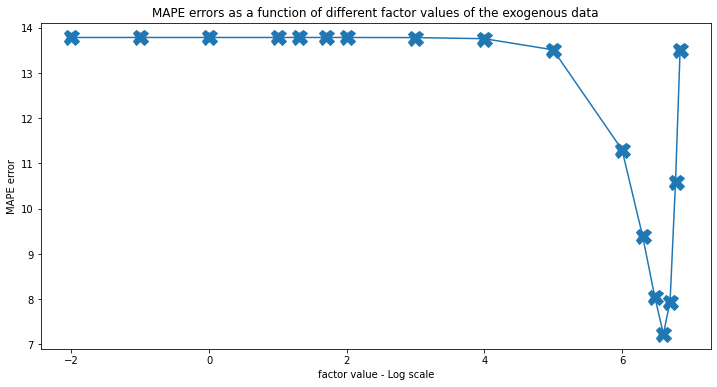

In [337]:
plt.figure(figsize=(12,6))
plt.plot(np.log10(fac_range),(err_list),'X-', ms=15)
plt.title('MAPE errors as a function of different factor values of the exogenous data')
plt.xlabel('factor value - Log scale')
plt.ylabel('MAPE error')

On the figure below I present the predictions of the model determining the benchmark value (without exogenous data) and the best model with exogenous data (factor = 4000000) together with confidence intervals (95%)

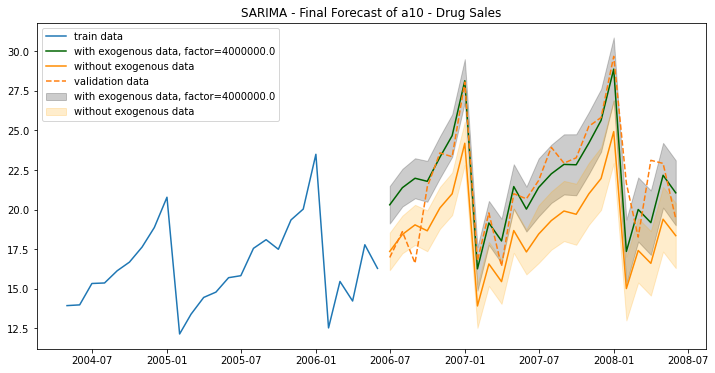

In [341]:
# Forecast
factor = 4000000.
n_periods = to_forecast # next 24 months
fitted_f, confint_f = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=factor*test[['seasonality']].values,
                                  return_conf_int=True)
index_of_fc = pd.date_range(test.index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series_f = pd.Series(fitted_f, index=index_of_fc)
lower_series_f = pd.Series(confint_f[:, 0], index=index_of_fc)
upper_series_f = pd.Series(confint_f[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index[-26:],train.value.values[-26:],label='train data')
plt.plot(fitted_series_f, color='darkgreen', label='with exogenous data, factor='+str(factor))
plt.fill_between(lower_series_f.index, 
                 lower_series_f, 
                 upper_series_f, 
                 color='k', alpha=.2, label='with exogenous data, factor='+str(factor))
plt.plot(fitted_series, color='darkorange',label='without exogenous data')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='orange', alpha=.2,label='without exogenous data')
plt.plot(test.index,test.value.values,'--',label='validation data')
plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.legend()
plt.show()

Below the graph showing the predictions with confidence intervals for those values of factors that lead to an increase of the mape error. For comparison the benchmark values are also shown.

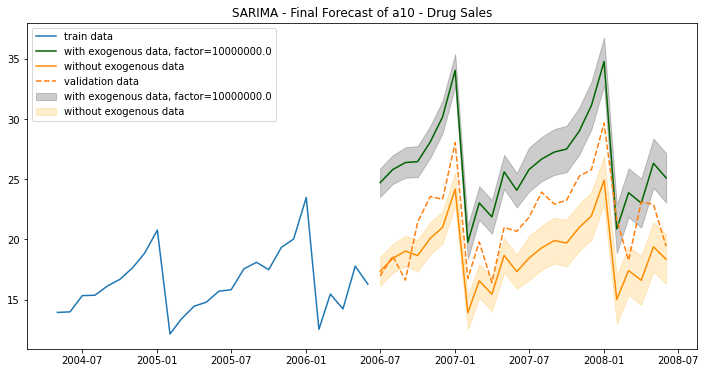

In [342]:
# Forecast
factor = 10000000.
n_periods = to_forecast # next 24 months
fitted_f, confint_f = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=factor*test[['seasonality']].values,
                                  return_conf_int=True)
index_of_fc = pd.date_range(test.index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series_f = pd.Series(fitted_f, index=index_of_fc)
lower_series_f = pd.Series(confint_f[:, 0], index=index_of_fc)
upper_series_f = pd.Series(confint_f[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index[-26:],train.value.values[-26:],label='train data')
plt.plot(fitted_series_f, color='darkgreen', label='with exogenous data, factor='+str(factor))
plt.fill_between(lower_series_f.index, 
                 lower_series_f, 
                 upper_series_f, 
                 color='k', alpha=.2, label='with exogenous data, factor='+str(factor))
plt.plot(fitted_series, color='darkorange',label='without exogenous data')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='orange', alpha=.2,label='without exogenous data')
plt.plot(test.index,test.value.values,'--',label='validation data')
plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.legend()
plt.show()